In [1]:
from typing import Callable, Generator, Tuple
from tqdm.notebook import tqdm
import numpy as np

Имеем Марковскую цепь:

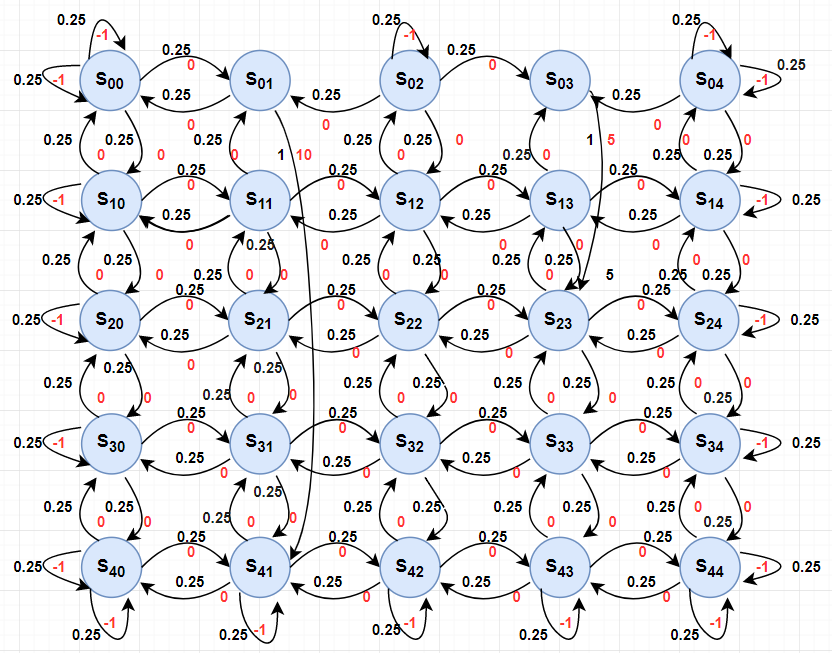

### Решение СЛАУ

Имеем уравнение: $\nu_{\pi}(s) = \sum_{a}{\pi(a|s)}\sum_{s'}\sum_{r}p(s',r|s,a)[r + \gamma\nu_{\pi}(s')]$

$\pi(a|s) = 1/4$ для обычных клеток (всего четыре различных действия), $\pi(a|s) = 1$ для клеток A и B (в них мы можем сделать только одно конкретное действие).

Таким образом, изначальная формула преобразуется в 

$\nu_{\pi}(s) = \begin{cases} \sum_{a}\frac{1}{4}(r_{a} + \gamma\nu_{\pi}(s'_{a})), & s \notin \{A,B\} \\ r + \gamma\nu_{\pi}(s'), & s \in \{A,B\} \end{cases}$

Подставив в формулу каждое состояние $s$, получим СЛАУ, решив которую, мы получим искомые стоимости.

Формула выше в матричном виде будет иметь вид $Ax + b = x$, 

где $b = (\sum_{a_{s_{1}}}\frac{1}{4}r_{a_{s_{1}}} \dots \sum_{a_{s_{n}}}\frac{1}{4}r_{a_{s_{n}}})^{T}$ - вектор свободных членов, которые являются матожиданием награды в соответствующих состояниях,

$x$ - вектор $\nu_{\pi}(s)$.

$a_{ij} = \begin{cases} \sum{\frac{\gamma}{4}}, & \mbox{если из состояния } s_{i} \mbox{ можно перейти в состояние } s_{j} \mbox{ и } s_{i} \notin \{A,B\} \mbox{. Сумма считается по всем действиям, в результате которых из состояния } s_{i} \mbox{ достигается состояние } s_{j}, \\ \gamma, & \mbox{если из состояния } s_{i} \mbox{ можно перейти в состояние } s_{j} \mbox{ и } s_{i} \in \{A,B\}, \\ 0, & \mbox{иначе.} \end{cases}$,


Преобразовав это уравнение (переносом x в левую часть), получим $(A-E)x = -b$, 

оно же $(E - A)x = b$.

In [71]:
def action_generator(i: int, j: int):
# Функция для генерации новых состояний с выигрышом для них
    possible_states = [
        (i+1, j),
        (i-1, j),
        (i, j+1),
        (i, j-1)
    ]
    
    # Шаг из А
    if i == 1 and j == 2:
        yield 5, 2, 10.
    # Шаг из B
    elif i == 1 and j == 4:
        yield 3, 4, 5.
    else:
        for state in possible_states:
            reward = 0.
            
            # Обработка шагов за пределы сетки
            if state[0] < 1 or state[0] > 5 or \
               state[1] < 1 or state[1] > 5:
                state = (i,j)
                reward = -1. / 4
                
            yield *state, reward      

In [72]:
def system_solution(
        action_generator: Callable[[int, int], Generator[Tuple[int, int, float], None, None]], # вызываемый объект, 
    # принимающий текущее состояние (начиная с (1,1)) и возвращающий следующее состояние (также начиная с (1,1)) и вознагр-ие
        n: int=5, 
        m: int=5,
        gamma: float=0.9 # коэффициент обесценивания
    ):
    n,m = 5,5
    a = np.eye(n*m) 
    b = np.zeros(n*m) 
    
    for i in range(n):
        for j in range(m):
            current_state = i*m + j
            states_to_update = dict() 
            
            # Вычисляем новое состояние и выигрыш для него
            for state_info in action_generator(i+1, j+1):
                next_state = (state_info[0]-1)*m + (state_info[1]-1)
                reward = state_info[2]
                
                # Обновляем значение в словаре или добавляем, если отсутствует
                if next_state in states_to_update:
                    states_to_update[next_state] += 1
                else:
                    states_to_update[next_state] = 1
                b[current_state] += reward # вычисляем вектор свободных членов
                
            states_cnt = sum(states_to_update[state] for state in states_to_update)
            for state in states_to_update:
                for _ in range(states_to_update[state]):
                    a[current_state, state] -= gamma / states_cnt # вычисляем a 
                    
    # Решаем СЛАУ и преобразуем к размеру (5, 5)
    result = np.linalg.solve(a, b)
    result.resize((n,m))
    
    return result

In [73]:
print(system_solution(action_generator))

[[ 3.30899634  8.78929186  4.42761918  5.32236759  1.49217876]
 [ 1.52158807  2.99231786  2.25013995  1.9075717   0.54740271]
 [ 0.05082249  0.73817059  0.67311326  0.35818621 -0.40314114]
 [-0.9735923  -0.43549543 -0.35488227 -0.58560509 -1.18307508]
 [-1.85770055 -1.34523126 -1.22926726 -1.42291815 -1.97517905]]


### Метод Монте-Карло

Определим функцию, которая делает броски по Монте-Карло и для перехода из одного состояния в другое пользуется предоставленной стратегией.

Стратегия - это функция, которая принимает на вход текущее состояние и возвращает следующее состояние и награду за переход в следующее состояние.

In [5]:
from typing import Callable, Tuple
import time
import numpy as np

def mc_solution(
        strategy: Callable[[int, int], Tuple[int, int, float]], 
        width: int=5, 
        height: int=5, 
        gamma: float=0.9, # коэффициент обесценивания
        exp_cnt: int=10**6, # кол-во экспериментов
        debug: bool = False,
    ):
    '''
    Функция моделирует эксперименты "exp_cnt` и извлекает среднее значение из результатов
    Возвращает numpy.ndarray размера height*width, элементы которого являются ценностями соответствующих состояний
    '''

    def _make_throw(i, j, gamma, gamma_i = -1):
        steps = 0
        eps = 10**(-20)
        res = 0.
        factor = gamma
        while factor >= eps:
            next_i, next_j, reward = strategy(i, j)
            i = next_i
            j = next_j
            factor = gamma ** steps
            res += reward * factor
            steps += 1
        return res

    result = np.zeros((height, width))
    
    for n_exp in tqdm(range(exp_cnt)):
        for i in range(height):
            for j in range(width):
                result[i,j] += _make_throw(i+1, j+1, gamma)
        if debug:
            if n_exp % 100 == 1:
                print(result/(n_exp + 1))

    return result / exp_cnt

Определим стратегию, которая соответствует нашей задаче.

In [6]:
import numpy as np

def strategy(i: int, j: int):
# Функция для генерации новых состояний с выигрышом для них
    possible_states = [
        (i+1, j),
        (i-1, j),
        (i, j+1),
        (i, j-1)
    ]
    reward = 0.
    
    next_state = possible_states[np.random.randint(0, len(possible_states))]
    
    # Шаг из А
    if i == 1 and j == 2:
        next_state = (5,2)
        reward = 10.
    # Шаг из B
    elif i == 1 and j == 4:
        next_state = (3,4)
        reward = 5.

    # Обработка шагов за пределы сетки
    if next_state[0] < 1 or next_state[0] > 5 or \
       next_state[1] < 1 or next_state[1] > 5:
        next_state = (i,j)
        reward = -1.
    
    return (*next_state, reward)

In [4]:
%%time
mc_solution(strategy, exp_cnt=1_000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 56.4 s, sys: 321 ms, total: 56.7 s
Wall time: 56.6 s


array([[ 3.21956849,  8.7303108 ,  4.55919551,  5.35386787,  1.66356125],
       [ 1.48245382,  3.19190794,  2.13693372,  2.01679994,  0.52822641],
       [ 0.01129439,  0.67449963,  0.51470552,  0.26250887, -0.38795267],
       [-1.07935692, -0.54202774, -0.42302657, -0.53743508, -1.06185416],
       [-2.00307579, -1.31725535, -1.16937563, -1.39049268, -1.95177365]])

In [7]:
%%time
mc_solution(strategy, exp_cnt=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 9min 29s, sys: 2.69 s, total: 9min 31s
Wall time: 9min 30s


array([[ 3.30387209,  8.77702821,  4.37379176,  5.27417618,  1.49037391],
       [ 1.47076116,  2.98042434,  2.26553571,  1.88971163,  0.55242766],
       [ 0.04848222,  0.68888642,  0.67658885,  0.38877276, -0.40220976],
       [-0.98508945, -0.42810423, -0.36843406, -0.56435336, -1.14713589],
       [-1.9082567 , -1.33397814, -1.24912001, -1.40873006, -1.98059439]])